In [1]:
import pandas as pd

from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF

import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

Load data to use as an actual function (represents the black box function from simulator)

In [2]:
df_rev_func = pd.read_csv('rev_func.csv')
df_rev_func = df_rev_func.set_index('vehicles')
df_rev_func = df_rev_func[['revenue']]
df_rev_func.head()

,revenue
vehicles,
1,60.000000
2,120.000000
3,179.880000
4,239.640240
5,299.280959


In [3]:
def target_func(number_of_vehicles):
    cost = number_of_vehicles * 29
    rev = df_rev_func.loc[number_of_vehicles-1]['revenue']
    profit = rev - cost
    return profit

Define some visualization and logic functions

In [4]:
### Vizualize gaussian process
def viz(grid, x_obs, y_obs):
    grid_size = len(grid)
    fig = plt.figure(figsize=(26, 10))

    title = 'Gaussian process for profit by fleet size'
    fig.suptitle(
        title,
        fontdict={'size':30}
    )

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])

    gpr.fit(x_obs, y_obs)
    mean, std = gpr.predict(grid, return_std=True)
    std = std.reshape(grid_size,1)
    lower_bound = mean - 1.9600 * std
    upper_bound = mean + 1.9600 * std

    axis.plot(x_obs, y_obs, 'D', markersize=8, label=u'Observations', color='b')
    axis.plot(grid, mean, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([grid, grid[::-1]]), 
              np.concatenate([lower_bound, upper_bound[::-1]]),
        alpha=.6, fc='y', ec='None', label='95% confidence interval')

    axis.set_xlim((100, 1000))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [5]:
def find_next_points(grid, gp_regressor, point_type='uncertain', std_units=1.96):
    mean, std = gpr.predict(grid, return_std=True)
    grid_size = len(grid)
    mean = mean.reshape([1,grid_size])[0]    
    
    if (point_type == 'uncertain'):
        return most_uncertain_x(grid, std)
    elif (point_type == 'optimum'):
        return optimum_next_x(grid, mean, std, std_units)
    elif (point_type == 'zero'):
        return zero_potential_x(grid, mean)
    else:
        return float('NaN')
    
def most_uncertain_x(grid, std):
    return grid[int(np.argmax(std))][0]
    
def zero_potential_x(grid, mean):
    neg_mean = [-1*x for x in np.abs(mean)]
    return grid[int(np.argmax(neg_mean))][0]

def optimum_next_x(grid, mean, std, std_units=1.96):
    upper_confidence_bound = mean + std_units * std  
    return grid[int(np.argmax(upper_confidence_bound))][0]

Get initial observations

In [6]:
x1, x2, x3 = 100, 550, 1000
y1 = target_func(x1)
y2 = target_func(x2)
y3 = target_func(x3)

print('100: ', y1)
print('550: ', y2)
print('1000: ', y3)

100:  2504.472371
550:  4094.8402700000006
1000:  -3008.1921699999984


Run Gaussian Process

In [7]:
normalization = 10000
x_observations = [[x1],[x2],[x3]]
y_observations = [[y1/normalization],[y2/normalization],[y3/normalization]]

x_min = 100
x_max = 1000
grid_size = 901

grid = np.linspace(x_min, x_max, grid_size).reshape(grid_size, 1)

gpr = GaussianProcessRegressor(
            kernel=Matern(nu=2.5),
            alpha=1e-5,
            normalize_y=True,
            n_restarts_optimizer=25)

gpr.fit(x_observations, y_observations)

most_uncertain = find_next_points(grid, gpr, point_type='uncertain')
optimum = find_next_points(grid, gpr, point_type='optimum')
zero_potential = find_next_points(grid, gpr, point_type='zero')

print('Most uncertain: ', most_uncertain)
print('Optimum: ', optimum)
print('Zero potential: ', zero_potential)

Most uncertain:  786.0
Optimum:  351.0
Zero potential:  825.0


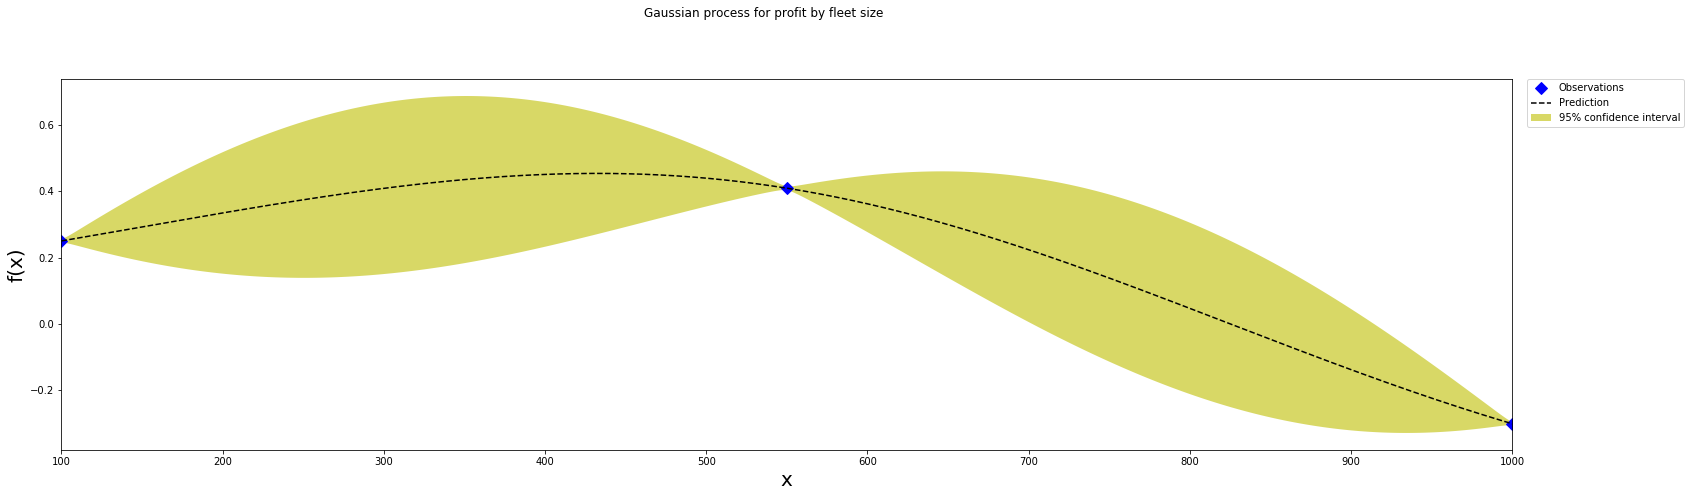

In [8]:
viz(grid, x_observations, y_observations)

Evaluate next point (most uncertain point)

In [9]:
new_y = target_func(most_uncertain)
print(new_y)

1021.9607599999981


Add new observation and fit the model

In [10]:
x_observations.append([most_uncertain])
y_observations.append([new_y/normalization])
gpr.fit(x_observations, y_observations)

most_uncertain = find_next_points(grid, gpr, point_type='uncertain')
optimum = find_next_points(grid, gpr, point_type='optimum')
zero_potential = find_next_points(grid, gpr, point_type='zero')

print('Most uncertain: ', most_uncertain)
print('Optimum: ', optimum)
print('Zero potential: ', zero_potential)

Most uncertain:  294.0
Optimum:  361.0
Zero potential:  841.0


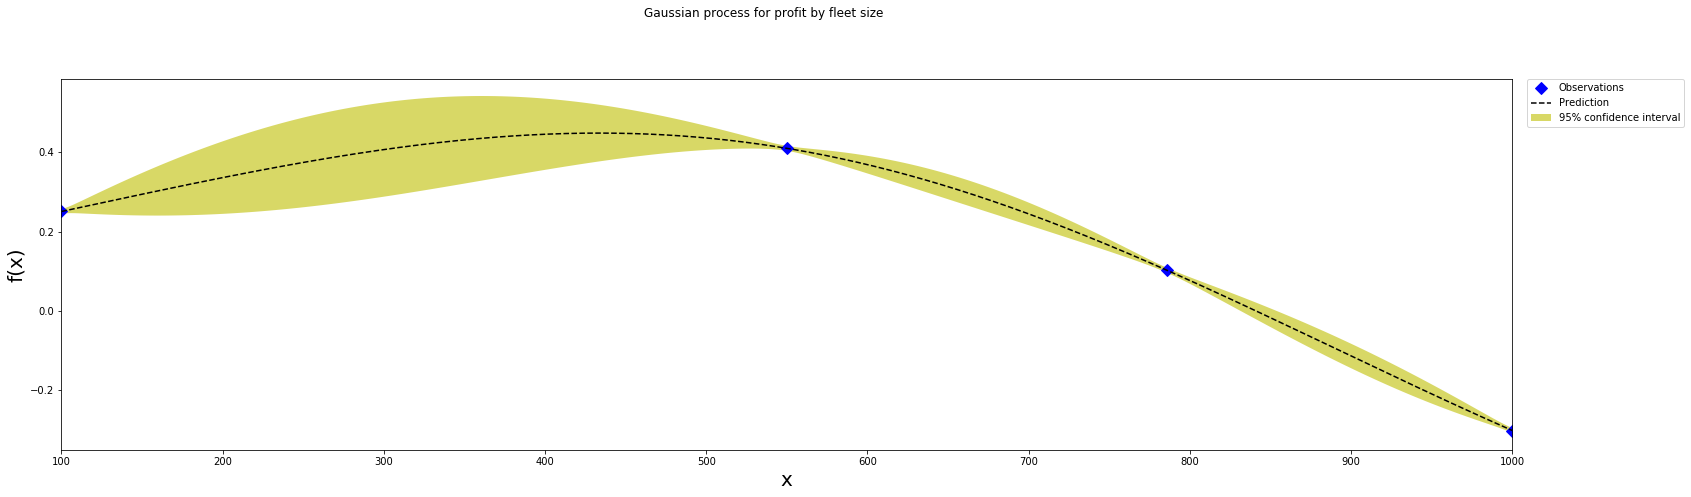

In [11]:
viz(grid, x_observations, y_observations)

Check standard deviation to get certainty level

In [12]:
mean, std = gpr.predict(grid, return_std=True)
std = std * normalization
print('Max standard deviation: $', np.max(std))

Max standard deviation: $ 605.5405982474789
